<a href="https://www.kaggle.com/code/tridibraj/brain-tumer-detection-densenet-201-and-resnet50?scriptVersionId=209361800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries import, Dataset paths, Transformations, Dataloader, Class labels

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import random
import os



train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'




train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet-201
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Plot training loss and accuracy

In [2]:

def plot_metrics(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Load pretrained DenseNet-201, Modify the final layer for 4 classes, Loss and optimizer

In [3]:

model = models.densenet201(pretrained=True)


model.classifier = nn.Linear(model.classifier.in_features, 4)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 217MB/s]


In [4]:
# Training function with loss and accuracy tracking
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Append loss and evaluate accuracy on validation set
        train_losses.append(running_loss / len(train_loader))
        val_accuracy = evaluate_model(model, test_loader, log=False)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_accuracies

# Evaluation function with additional metrics
def evaluate_model(model, test_loader, log=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    if log:
        print(f"Test Accuracy: {accuracy:.2f}%")
        print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    return accuracy

In [5]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Train and evaluate the model

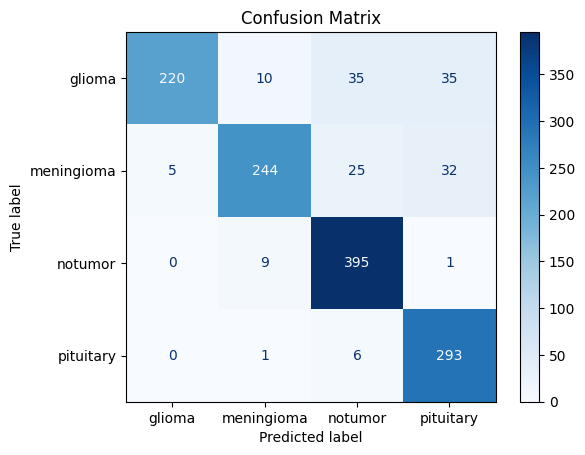

Epoch [1/6], Loss: 0.3385, Validation Accuracy: 87.87%


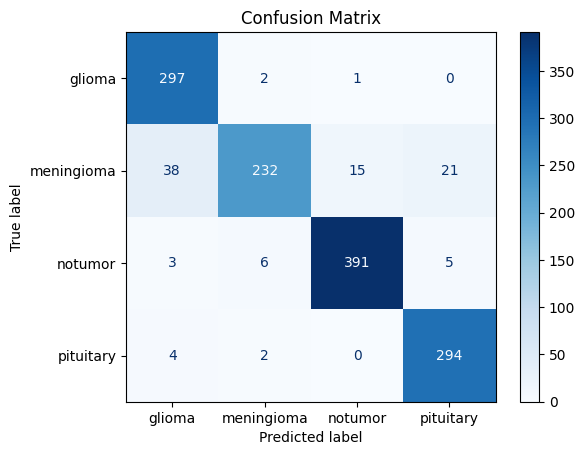

Epoch [2/6], Loss: 0.1991, Validation Accuracy: 92.60%


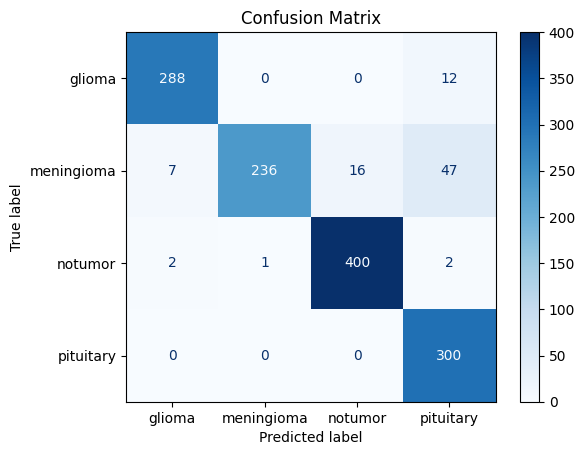

Epoch [3/6], Loss: 0.1687, Validation Accuracy: 93.36%


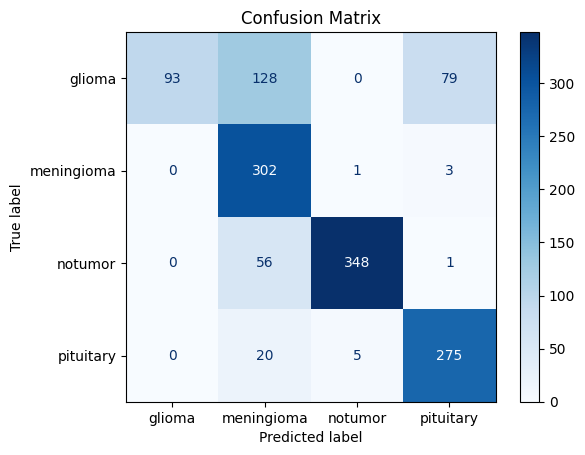

Epoch [4/6], Loss: 0.1237, Validation Accuracy: 77.65%


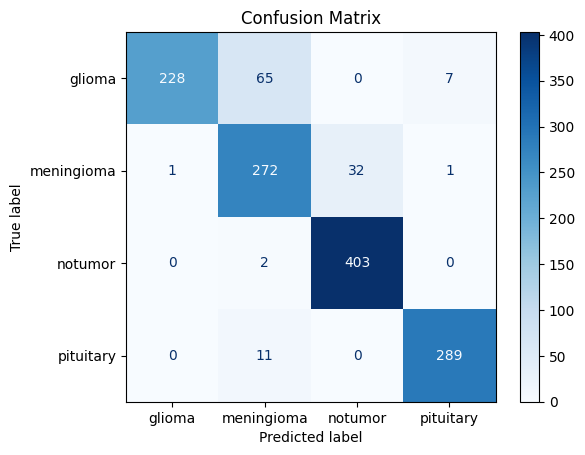

Epoch [5/6], Loss: 0.0942, Validation Accuracy: 90.92%


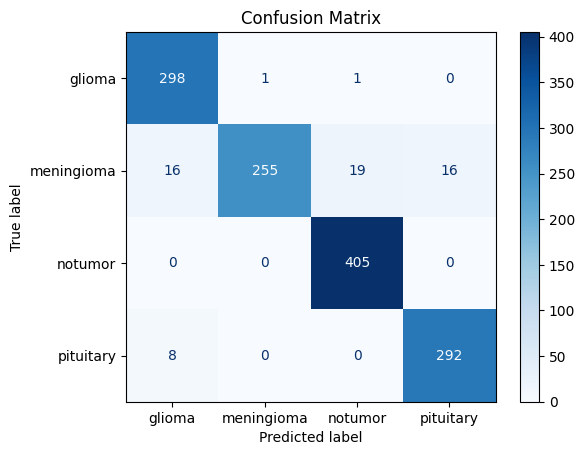

Epoch [6/6], Loss: 0.1008, Validation Accuracy: 95.35%


In [6]:

num_epochs = 6
train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)


# Plot metrics

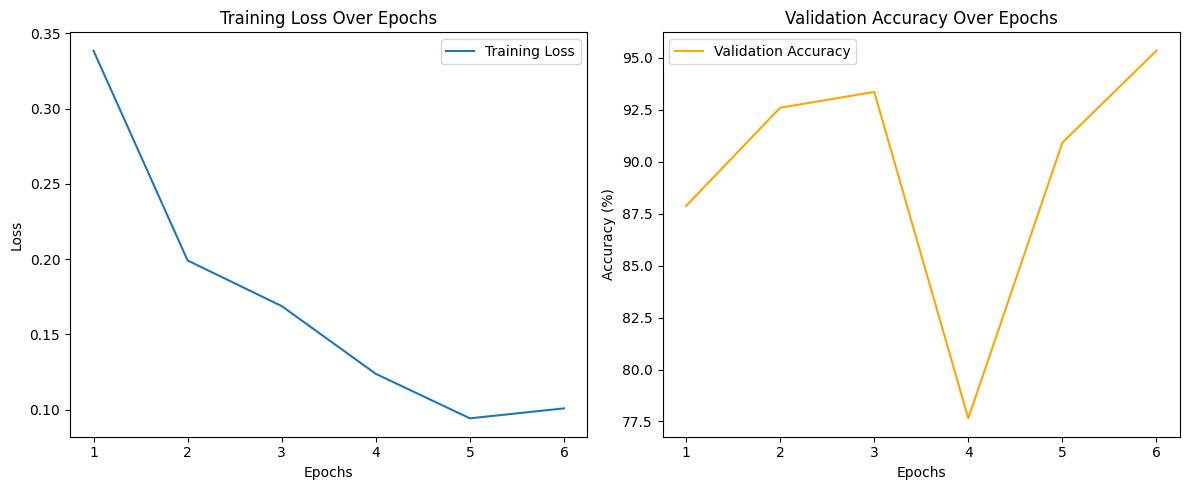

In [7]:

plot_metrics(train_losses, val_accuracies)

# Evaluate on test set with metrics

Test Accuracy: 95.35%
              precision    recall  f1-score   support

      glioma       0.93      0.99      0.96       300
  meningioma       1.00      0.83      0.91       306
     notumor       0.95      1.00      0.98       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



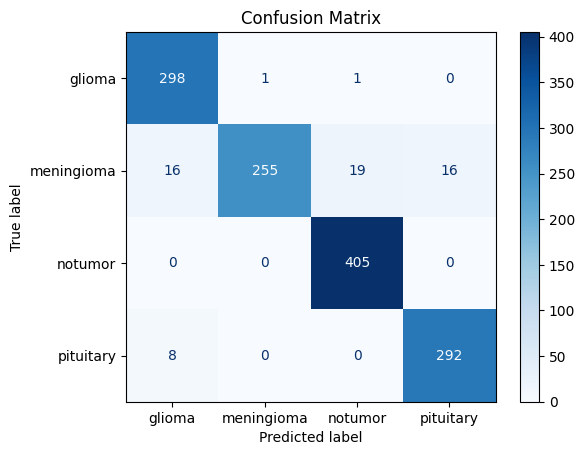

95.34706331045004

In [8]:

evaluate_model(model, test_loader)

# Save the model

In [9]:

save_path = '/kaggle/working/densenet201_brain_tumor.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /kaggle/working/densenet201_brain_tumor.pth


# Test the Model

In [10]:

test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
model_path = '/kaggle/working/densenet201_brain_tumor.pth'

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/2518876194.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

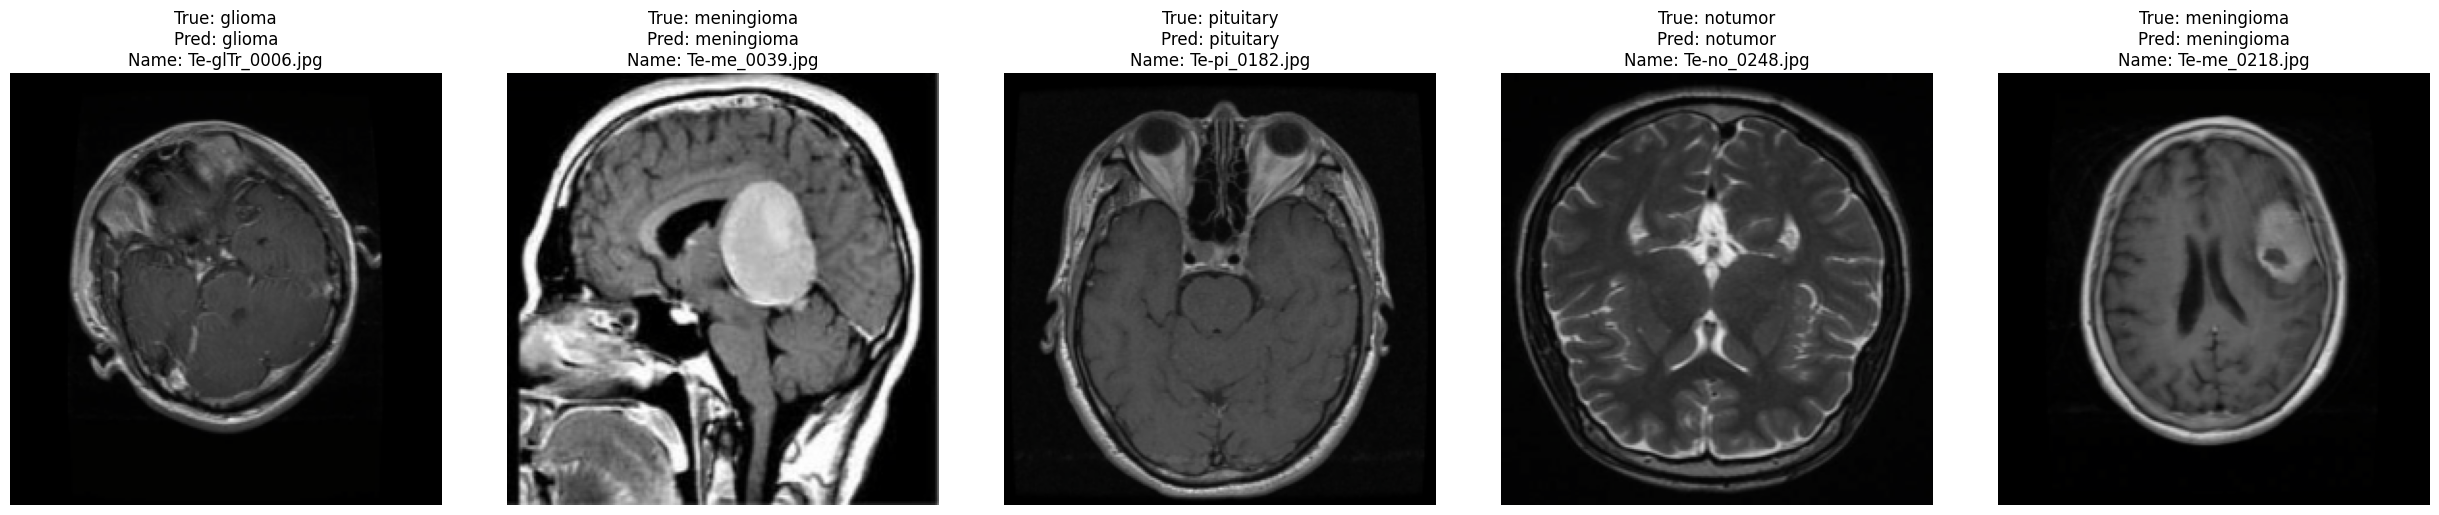

In [11]:
model = models.densenet201(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(class_names))  # Update for 4 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()



# Function to visualize predictions
def test_random_images(model, dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image_for_plot = image.permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        image_for_plot = image_for_plot * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))  # Add batch dimension and send to device
            _, predicted = torch.max(output, 1)
        
        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_for_plot)
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



# Function to visualize predictions with grid layout
def test_random_images_grid(model, dataset, num_images=20, images_per_row=6):
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows
    plt.figure(figsize=(images_per_row * 5, num_rows * 5))  # Adjust figure size based on rows and columns
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)  # Randomly select an image
        image, label = dataset[idx]
        image_for_plot = image.permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        image_for_plot = image_for_plot * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
        
        # Get the image filename
        image_path = dataset.samples[idx][0]
        image_name = os.path.basename(image_path)
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))  # Add batch dimension and send to device
            _, predicted = torch.max(output, 1)
        
        # Plot the image
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image_for_plot)
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}\nName: {image_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test random images with grid layout
test_random_images_grid(model, test_dataset, num_images=5, images_per_row=5)



# Load pretrained ResNet50

In [12]:
model = models.resnet50(pretrained=True)

# Modify the final layer for 4 classes
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


# Training, evaluation, and saving follow the same process as before

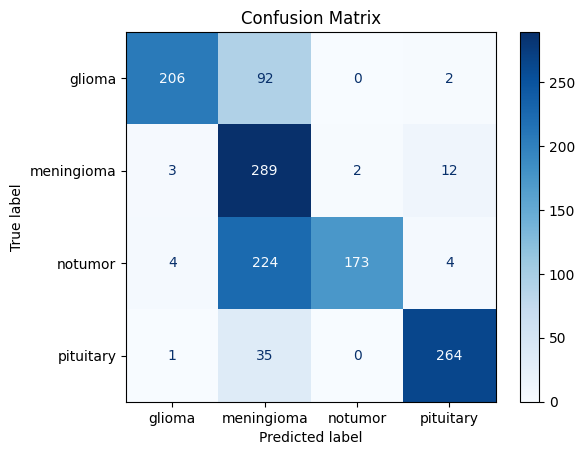

Epoch [1/10], Loss: 0.4546, Validation Accuracy: 71.09%


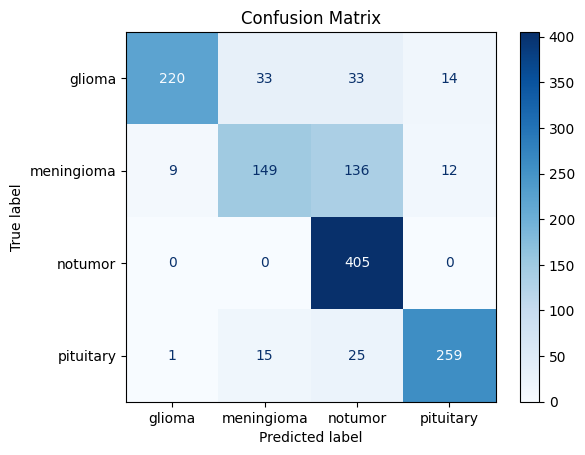

Epoch [2/10], Loss: 0.2889, Validation Accuracy: 78.79%


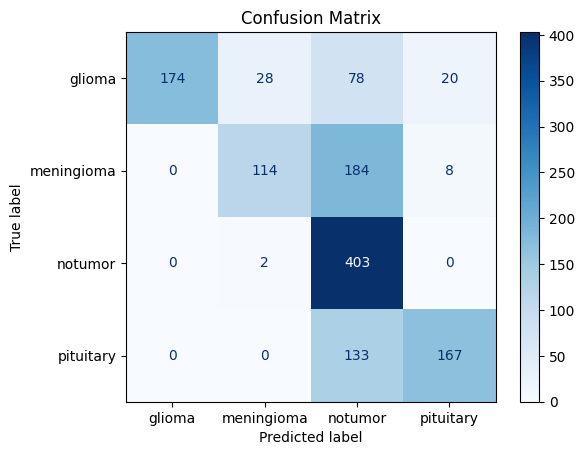

Epoch [3/10], Loss: 0.2154, Validation Accuracy: 65.45%


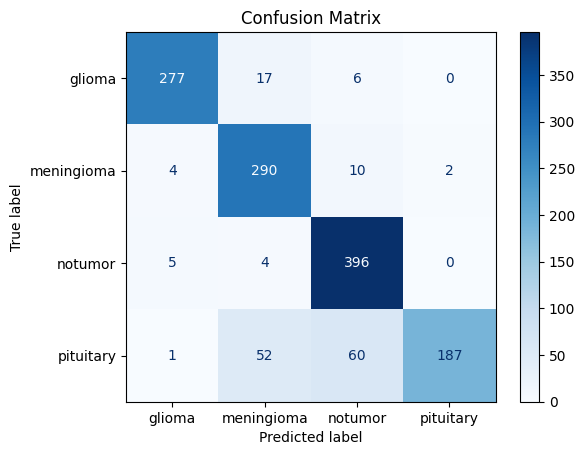

Epoch [4/10], Loss: 0.1910, Validation Accuracy: 87.72%


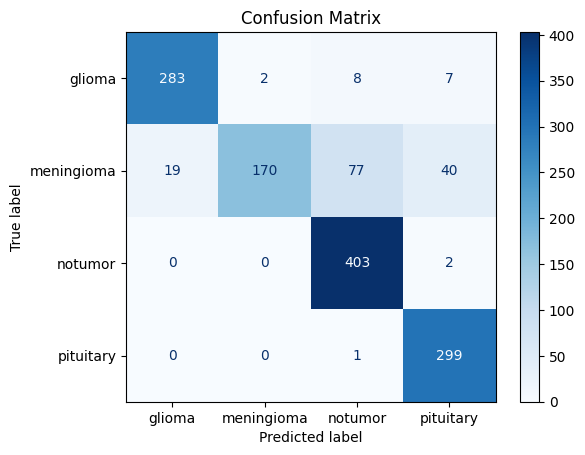

Epoch [5/10], Loss: 0.1632, Validation Accuracy: 88.10%


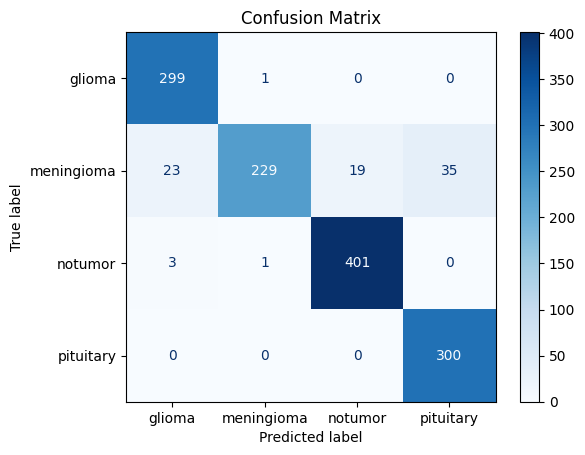

Epoch [6/10], Loss: 0.1279, Validation Accuracy: 93.75%


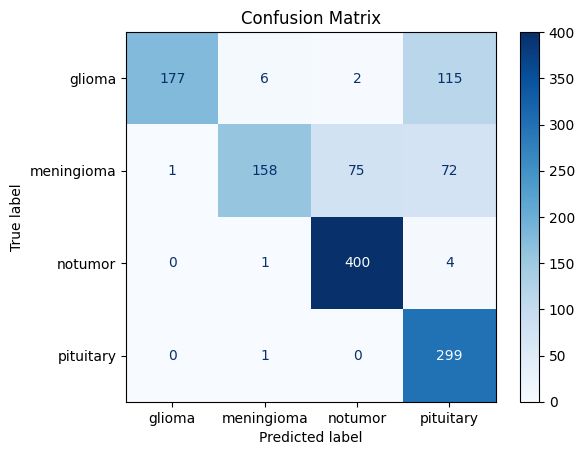

Epoch [7/10], Loss: 0.1395, Validation Accuracy: 78.87%


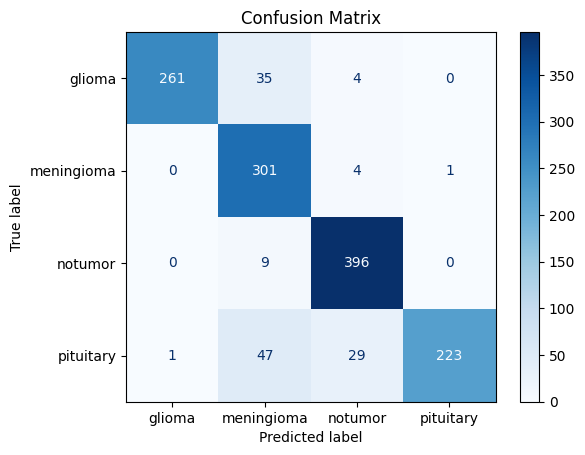

Epoch [8/10], Loss: 0.1180, Validation Accuracy: 90.08%


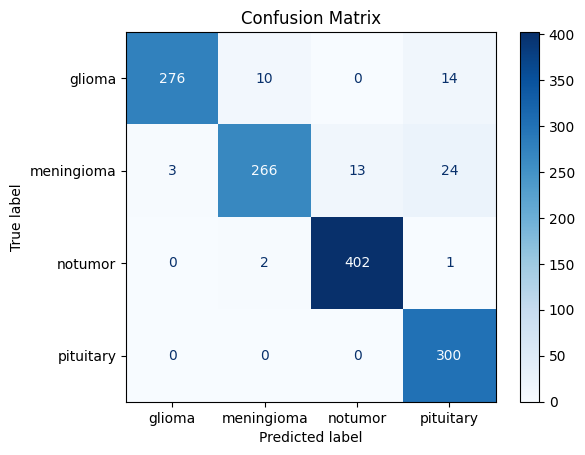

Epoch [9/10], Loss: 0.1199, Validation Accuracy: 94.89%


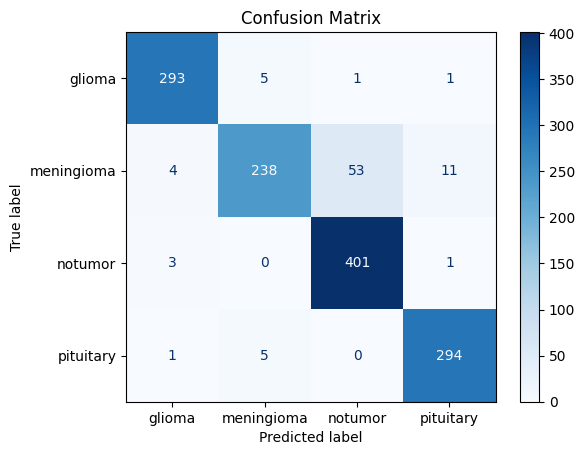

Epoch [10/10], Loss: 0.0907, Validation Accuracy: 93.52%


In [13]:
num_epochs = 10
train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)

In [14]:
# Save the model
save_path = '/kaggle/working/resnet50_brain_tumor.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /kaggle/working/resnet50_brain_tumor.pth


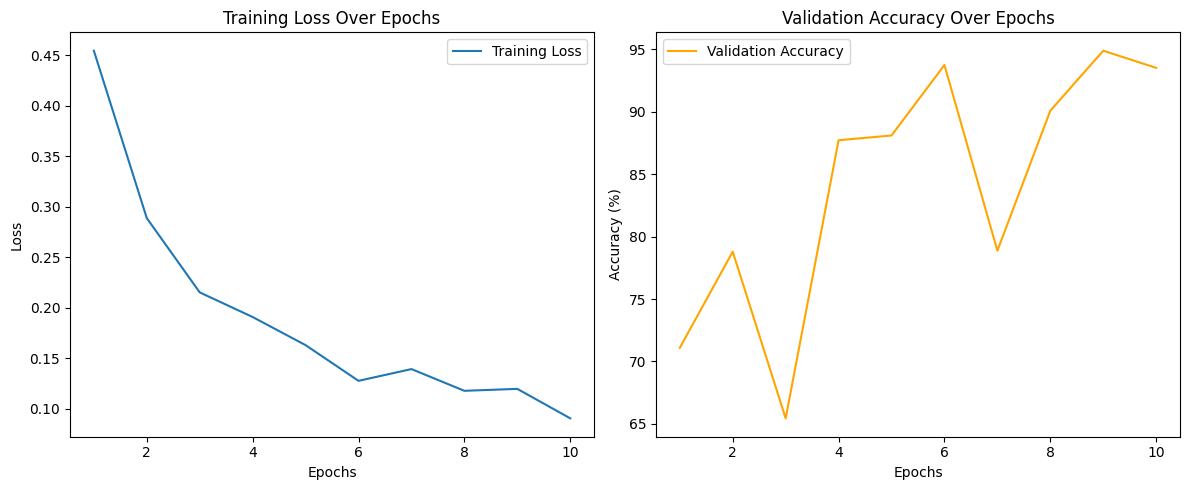

Test Accuracy: 93.52%
              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.96      0.78      0.86       306
     notumor       0.88      0.99      0.93       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.93      1311



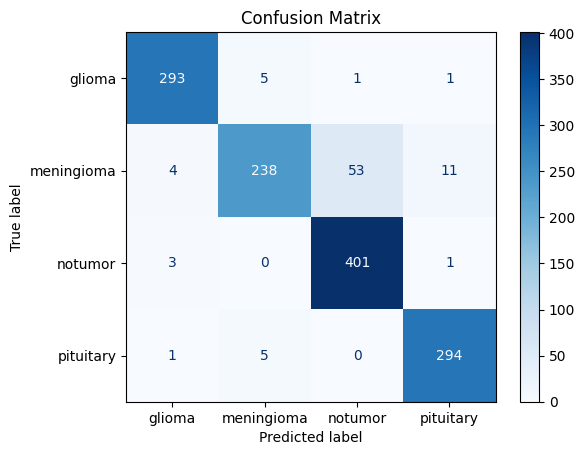

93.5163996948894

In [15]:
# Plot metrics
plot_metrics(train_losses, val_accuracies)

# Evaluate on test set with metrics
evaluate_model(model, test_loader)

# Load pre-trained ViT model (ViT-B16)

In [ ]:
# Import necessary modules
from torchvision import models

# Load the pre-trained ViT model
model = models.vit_b_16(pretrained=True)

# Check the classifier layer's name
# print(model)

# Modify the classifier for 4 output classes
model.heads.head = nn.Linear(model.heads.head.in_features, len(class_names))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:


# # Training function
# def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
#     train_losses = []
#     val_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
        
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
            
#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()
        
#         # Append loss and evaluate accuracy on validation set
#         train_losses.append(running_loss / len(train_loader))
#         val_accuracy = evaluate_model(model, test_loader, log=False)
#         val_accuracies.append(val_accuracy)
        
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
#     return train_losses, val_accuracies

# # Evaluation function
# def evaluate_model(model, test_loader, log=True):
#     model.eval()
#     correct = 0
#     total = 0
#     all_labels = []
#     all_preds = []
    
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
            
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
            
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())
    
#     accuracy = 100 * correct / total
#     if log:
#         print(f"Test Accuracy: {accuracy:.2f}%")
#         print(classification_report(all_labels, all_preds, target_names=class_names))
    
#     return accuracy

In [ ]:
# Train and evaluate the model
num_epochs = 10
train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)


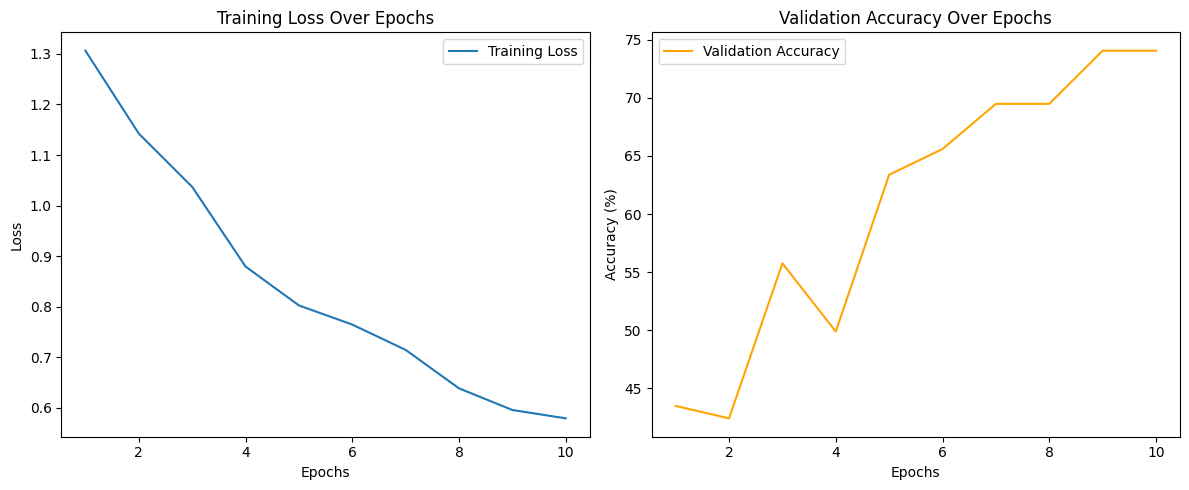

Test Accuracy: 74.07%
              precision    recall  f1-score   support

      glioma       0.64      0.79      0.71       300
  meningioma       0.61      0.46      0.52       306
     notumor       0.81      0.92      0.86       405
   pituitary       0.88      0.74      0.80       300

    accuracy                           0.74      1311
   macro avg       0.74      0.73      0.72      1311
weighted avg       0.74      0.74      0.73      1311



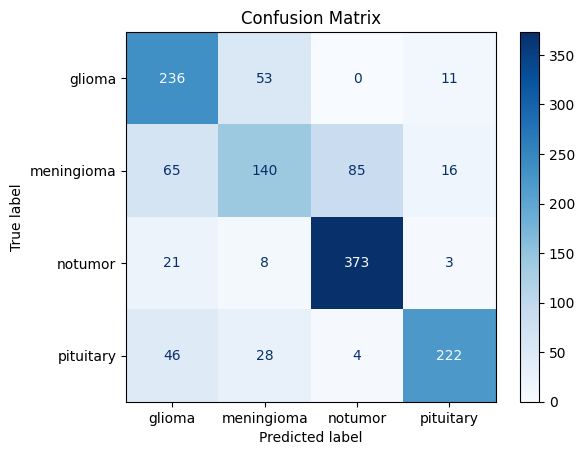

Model saved to /kaggle/working/vit_brain_tumor.pth


In [19]:
# Plot metrics
plot_metrics(train_losses, val_accuracies)

# Evaluate on test set
evaluate_model(model, test_loader)

# Save the model
save_path = '/kaggle/working/vit_brain_tumor.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")
